In [29]:
import yfinance as yf

symbols = ["AAPL","MSFT","TSLA","SPY","QQQ"]
data = {}

for s in symbols:
    df = yf.download(s, period="2y", interval="1d", group_by="column", auto_adjust=False, progress=False)
    data[s] = df


In [30]:

import pandas as pd
import numpy as np

def sanitize_ohlc(df):
    # Keep only required cols (some downloads include Adj Close etc.)
    df = df.copy()

    # If columns are MultiIndex, flatten them
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = [c[0] for c in df.columns]

    df = df[['Open','High','Low','Close','Volume']]

    # Ensure datetime index
    df.index = pd.to_datetime(df.index)

    # Convert everything to numeric and drop bad rows
    df = df.apply(pd.to_numeric, errors='coerce').dropna()

    for c in ['Open','High','Low','Close']:
        df[c] = df[c].astype(float).map(lambda x: float(x))
    df['Volume'] = df['Volume'].astype(float).map(lambda x: int(x))

    return df


In [31]:
import mplfinance as mpf
import os

os.makedirs("images", exist_ok=True)

WINDOW = 30
count = 0

for symbol, df in data.items():
    df = sanitize_ohlc(df)

    print(symbol, type(df['Open'].iloc[0]), df['Open'].iloc[0])

    for i in range(len(df) - WINDOW):
        window = df.iloc[i:i+WINDOW]

        fname = f"images/{symbol}_{i}.png"
        mpf.plot(window, type="candle", style="charles", volume=False, savefig=fname)

        count += 1

print("Total images:", count)


AAPL <class 'numpy.float64'> 184.35000610351562
MSFT <class 'numpy.float64'> 376.3699951171875
TSLA <class 'numpy.float64'> 235.10000610351562
SPY <class 'numpy.float64'> 474.1600036621094
QQQ <class 'numpy.float64'> 406.07000732421875
Total images: 2360


In [32]:
import pandas as pd
import numpy as np
import os

WINDOW = 30
rows = []

for symbol, df in data.items():
    df = sanitize_ohlc(df)

    for i in range(len(df) - WINDOW):
        window = df.iloc[i:i+WINDOW]
        fname = f"images/{symbol}_{i}.png"

        rows.append({
            "file": fname,
            "symbol": symbol,
            "start": str(window.index[0].date()),
            "end": str(window.index[-1].date()),
            "open": float(window["Open"].iloc[-1]),
            "high": float(window["High"].iloc[-1]),
            "low": float(window["Low"].iloc[-1]),
            "close": float(window["Close"].iloc[-1]),
            "prev_close": float(window["Close"].iloc[-2]),
        })

meta = pd.DataFrame(rows)
meta.to_csv("image_meta.csv", index=False)
meta.head()


,file,symbol,start,end,open,high,low,close,prev_close
0,images/AAPL_0.png,AAPL,2024-01-10,2024-02-22,183.479996,184.960007,182.460007,184.369995,182.320007
1,images/AAPL_1.png,AAPL,2024-01-11,2024-02-23,185.009995,185.039993,182.229996,182.520004,184.369995
2,images/AAPL_2.png,AAPL,2024-01-12,2024-02-26,182.240005,182.759995,180.649994,181.160004,182.520004
3,images/AAPL_3.png,AAPL,2024-01-16,2024-02-27,181.100006,183.919998,179.559998,182.630005,181.160004
4,images/AAPL_4.png,AAPL,2024-01-17,2024-02-28,182.509995,183.119995,180.130005,181.419998,182.630005


In [33]:
def label_doji(o,h,l,c):
    body = abs(c - o)
    rng = h - l
    return (rng > 0) and (body <= 0.1 * rng)
def label_hammer(o,h,l,c):
    body = abs(c - o)
    lower = min(o,c) - l
    upper = h - max(o,c)
    return (body > 0) and (lower >= 2*body) and (upper <= 0.5*body)
def label_head_shoulders(close_series):
    # crude: middle peak higher than left/right peaks
    c = np.array(close_series)
    left = c[8:12].max()
    head = c[13:17].max()
    right = c[18:22].max()
    return (head > left) and (head > right)
labels = []

for idx, row in meta.iterrows():
    # for doji/hammer we use last candle (end of window)
    o,h,l,c = row["open"], row["high"], row["low"], row["close"]

    # We need the whole window closes for H&S
    symbol = row["symbol"]
    i = int(row["file"].split("_")[-1].split(".")[0])  # extracts i from AAPL_123.png
    df = sanitize_ohlc(data[symbol])
    window = df.iloc[i:i+WINDOW]

    if label_doji(o,h,l,c):
        labels.append("Doji")
    elif label_hammer(o,h,l,c):
        labels.append("Hammer")
    elif label_head_shoulders(window["Close"].values):
        labels.append("HeadShoulders")
    else:
        labels.append("None")

meta["label"] = labels
meta.to_csv("image_meta_labeled.csv", index=False)

meta["label"].value_counts()


,count
label,
None,1585
HeadShoulders,457
Doji,247
Hammer,71


In [34]:
from sklearn.utils import resample

dfs = []
MIN = meta["label"].value_counts().min()   # this will be 71

for lab in ["HeadShoulders", "Doji", "Hammer", "None"]:
    sub = meta[meta["label"] == lab]
    if len(sub) > MIN:
        sub = resample(sub, replace=False, n_samples=MIN, random_state=42)
    dfs.append(sub)

balanced = pd.concat(dfs).sample(frac=1, random_state=42)

balanced["label"].value_counts()


,count
label,
HeadShoulders,71
None,71
Hammer,71
Doji,71


In [35]:
from sklearn.model_selection import train_test_split
import shutil, os

BASE = "/content/pattern_dataset"
shutil.rmtree(BASE, ignore_errors=True)

for split in ["train","val","test"]:
    for lab in ["Doji","Hammer","HeadShoulders","None"]:
        os.makedirs(f"{BASE}/{split}/{lab}", exist_ok=True)

train_df, temp_df = train_test_split(
    balanced, test_size=0.3, stratify=balanced["label"], random_state=42
)

val_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df["label"], random_state=42
)

def copy_split(df, split):
    for _, r in df.iterrows():
        shutil.copy(r["file"], f"{BASE}/{split}/{r['label']}/" + os.path.basename(r["file"]))

copy_split(train_df, "train")
copy_split(val_df, "val")
copy_split(test_df, "test")

print("Dataset rebuilt.")


Dataset rebuilt.


In [36]:
balanced["label"].value_counts()


,count
label,
HeadShoulders,71
None,71
Hammer,71
Doji,71


In [37]:
import tensorflow as tf
import os

BASE = "/content/pattern_dataset"
IMG_SIZE = (128,128)
BATCH_SIZE = 32
SEED = 42

train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(BASE, "train"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(BASE, "val"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED,
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(BASE, "test"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED,
    shuffle=False
)

class_names = train_ds.class_names
print("Classes:", class_names)


Found 198 files belonging to 4 classes.
Found 43 files belonging to 4 classes.
Found 43 files belonging to 4 classes.
Classes: ['Doji', 'Hammer', 'HeadShoulders', 'None']


In [38]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)
test_ds  = test_ds.cache().prefetch(AUTOTUNE)
data_aug = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.03),
    tf.keras.layers.RandomZoom(0.10),
    tf.keras.layers.RandomTranslation(0.05, 0.05),
])
inputs = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

x = data_aug(inputs)
x = tf.keras.layers.Rescaling(1./255)(x)

x = tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu")(x)
x = tf.keras.layers.MaxPooling2D()(x)

x = tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu")(x)
x = tf.keras.layers.MaxPooling2D()(x)

x = tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu")(x)
x = tf.keras.layers.MaxPooling2D()(x)

x = tf.keras.layers.Dropout(0.35)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dropout(0.35)(x)

outputs = tf.keras.layers.Dense(len(class_names), activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,288,196 (16.36 MB)

 Trainable params: 4,288,196 (16.36 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
import numpy as np
from collections import Counter

y_all = []
for _, y in train_ds.unbatch():
    y_all.append(int(y.numpy()))

counts = Counter(y_all)
total = sum(counts.values())

class_weight = {k: total/(len(counts)*v) for k,v in counts.items()}
print("Class counts:", counts)
print("Class weights:", class_weight)


Class counts: Counter({1: 50, 3: 50, 2: 49, 0: 49})
Class weights: {1: 0.99, 3: 0.99, 2: 1.010204081632653, 0: 1.010204081632653}


In [40]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    class_weight=class_weight,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5)
    ]
)


Epoch 1/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.2770 - loss: 2.7592 - val_accuracy: 0.2558 - val_loss: 1.3879 - learning_rate: 0.0010
Epoch 2/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.2924 - loss: 1.3884 - val_accuracy: 0.2558 - val_loss: 1.3870 - learning_rate: 0.0010
Epoch 3/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.2343 - loss: 1.3890 - val_accuracy: 0.2558 - val_loss: 1.3891 - learning_rate: 0.0010
Epoch 4/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.2741 - loss: 1.3935 - val_accuracy: 0.2558 - val_loss: 1.3860 - learning_rate: 0.0010
Epoch 5/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.2316 - loss: 1.3868 - val_accuracy: 0.2558 - val_loss: 1.3858 - learning_rate: 0.0010
Epoch 6/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.1944 - loss: 1.3866 - val_accuracy: 0.2558 - val_loss: 1.3863 - learning_rate: 0.0010
Epoch 7/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.3021 - loss: 1.3849 - val_accuracy: 0.2558 - val_loss

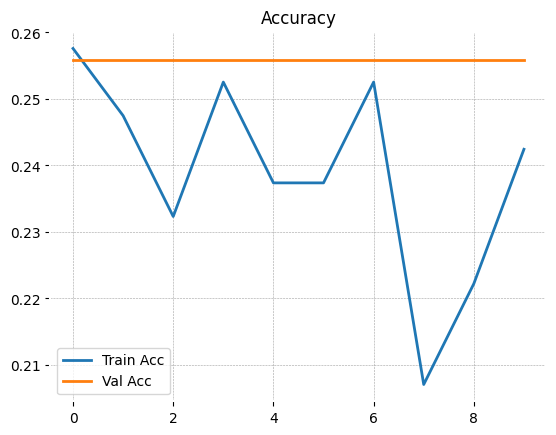

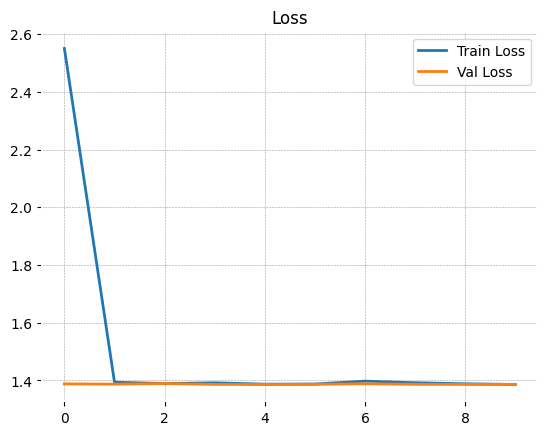

In [41]:
import matplotlib.pyplot as plt

plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.legend(); plt.title("Accuracy"); plt.show()

plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend(); plt.title("Loss"); plt.show()


In [42]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Collect predictions
y_true, y_pred = [], []

for x_batch, y_batch in test_ds:
    probs = model.predict(x_batch, verbose=0)
    preds = np.argmax(probs, axis=1)

    y_true.extend(y_batch.numpy().astype(int))
    y_pred.extend(preds.astype(int))

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)


Classification Report:

               precision    recall  f1-score   support

         Doji       0.26      1.00      0.41        11
       Hammer       0.00      0.00      0.00        11
HeadShoulders       0.00      0.00      0.00        11
         None       0.00      0.00      0.00        10

     accuracy                           0.26        43
    macro avg       0.06      0.25      0.10        43
 weighted avg       0.07      0.26      0.10        43

Confusion Matrix:
 [[11  0  0  0]
 [11  0  0  0]
 [11  0  0  0]
 [10  0  0  0]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Found 43 files belonging to 4 classes.
Classes: ['Doji', 'Hammer', 'HeadShoulders', 'None']
Num test images: 43

=== Classification Report (Test) ===
               precision    recall  f1-score   support

         Doji       0.26      1.00      0.41        11
       Hammer       0.00      0.00      0.00        11
HeadShoulders       0.00      0.00      0.00        11
         None       0.00      0.00      0.00        10

     accuracy                           0.26        43
    macro avg       0.06      0.25      0.10        43
 weighted avg       0.07      0.26      0.10        43

=== Confusion Matrix ===
[[11  0  0  0]
 [11  0  0  0]
 [11  0  0  0]
 [10  0  0  0]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


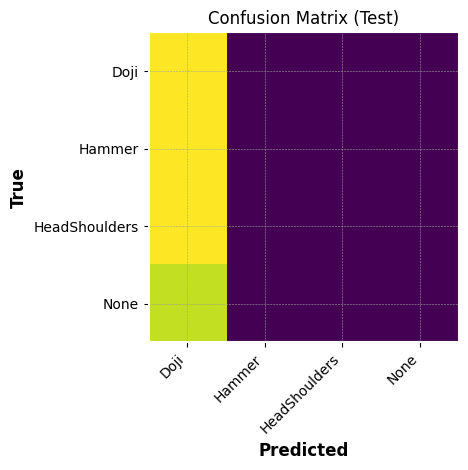


Backtest rows: 43
                                              file symbol    i pred_label  \
0  /content/pattern_dataset/test/Doji/AAPL_112.png   AAPL  112       Doji   
1  /content/pattern_dataset/test/Doji/AAPL_123.png   AAPL  123       Doji   
2  /content/pattern_dataset/test/Doji/AAPL_163.png   AAPL  163       Doji   
3  /content/pattern_dataset/test/Doji/AAPL_349.png   AAPL  349       Doji   
4   /content/pattern_dataset/test/Doji/AAPL_78.png   AAPL   78       Doji   

  signal  today_close  next_close  strategy_return  
0    BUY   219.860001  209.270004        -0.048167  
1    BUY   225.889999  226.509995         0.002745  
2    BUY   233.850006  231.779999        -0.008852  
3    BUY   210.160004  210.020004        -0.000666  
4    BUY   214.240005  212.490005        -0.008168  

=== Strategy Performance ===
Samples evaluated: 43
Trades (non-HOLD): 43
Win rate (on trades only): 0.4883720930232558
Avg return per sample: -0.00208139657562869
Total return (sum of returns): -0.08

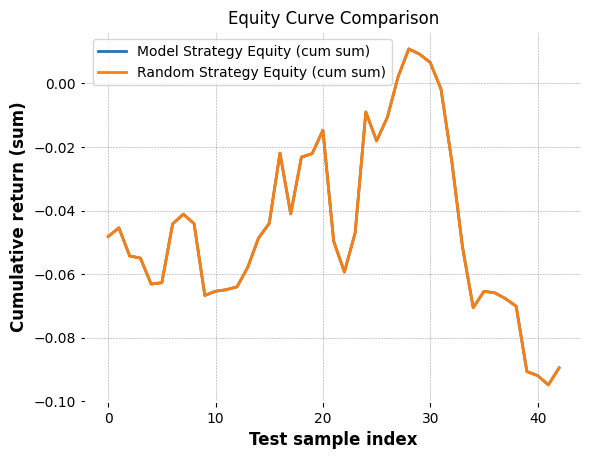


Saved: backtest_results.csv


In [43]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# ---------- CONFIG ----------
WINDOW = 30
THRESHOLD_PROBA = None  # not used for softmax; keep None

# ---------- 1) Reload test dataset WITH file paths in order ----------
test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(BASE, "test"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)
class_names = test_ds.class_names
file_list = test_ds.file_paths

print("Classes:", class_names)
print("Num test images:", len(file_list))

# ---------- 2) Predict on test set ----------
y_true, y_pred = [], []

for x_batch, y_batch in test_ds:
    probs = model.predict(x_batch, verbose=0)          # shape: (batch, num_classes)
    preds = np.argmax(probs, axis=1)                   # predicted class indices
    y_true.extend(y_batch.numpy().astype(int))
    y_pred.extend(preds.astype(int))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# ---------- 3) Classification metrics (accuracy, precision, recall, F1) ----------
print("\n=== Classification Report (Test) ===")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
print("=== Confusion Matrix ===")
print(cm)

plt.figure()
plt.imshow(cm)
plt.title("Confusion Matrix (Test)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(range(len(class_names)), class_names, rotation=45, ha="right")
plt.yticks(range(len(class_names)), class_names)
plt.tight_layout()
plt.show()

# ---------- Helpers ----------
def parse_symbol_i(filepath):
    base = os.path.basename(filepath)  # e.g. "SPY_58.png"
    sym, idx = base.replace(".png","").split("_")
    return sym, int(idx)

def signal_from_label(label):
    # Simple strategy:
    # BUY on Doji/Hammer, SELL on HeadShoulders, HOLD on None
    if label in ["Doji", "Hammer"]:
        return "BUY"
    if label == "HeadShoulders":
        return "SELL"
    return "HOLD"

# ---------- 4) Build backtest table ----------
records = []


for fp, pred_class in zip(file_list, y_pred):
    sym, i = parse_symbol_i(fp)

    # Get OHLC for that symbol
    df = sanitize_ohlc(data[sym])

    # Window used to create the image
    if i + WINDOW >= len(df):   # if window exceeds bounds
        continue

    window = df.iloc[i:i+WINDOW]
    today_close = float(window["Close"].iloc[-1])

    # Next day close after window end
    next_idx = i + WINDOW
    if next_idx >= len(df):
        continue
    next_close = float(df["Close"].iloc[next_idx])

    # Returns (percentage)
    ret_buy  = (next_close - today_close) / today_close
    ret_sell = (today_close - next_close) / today_close

    pred_label = class_names[int(pred_class)]
    signal = signal_from_label(pred_label)

    if signal == "BUY":
        strat_ret = ret_buy
    elif signal == "SELL":
        strat_ret = ret_sell
    else:
        strat_ret = 0.0

    records.append({
        "file": fp,
        "symbol": sym,
        "i": i,
        "pred_label": pred_label,
        "signal": signal,
        "today_close": today_close,
        "next_close": next_close,
        "strategy_return": strat_ret
    })

bt = pd.DataFrame(records)

print("\nBacktest rows:", len(bt))
print(bt.head())

# ---------- 5) Strategy performance metrics ----------
r = bt["strategy_return"].values

trades = np.sum(bt["signal"].values != "HOLD")
win_rate = np.mean(r[r != 0] > 0) if trades > 0 else 0.0
avg_ret = np.mean(r) if len(r) > 0 else 0.0
total_ret = np.sum(r) if len(r) > 0 else 0.0
std = np.std(r) if len(r) > 0 else 0.0

# Simple Sharpe-like ratio
sharpe = (avg_ret / std) * np.sqrt(len(r)) if std > 1e-12 else 0.0

print("\n=== Strategy Performance ===")
print("Samples evaluated:", len(r))
print("Trades (non-HOLD):", int(trades))
print("Win rate (on trades only):", win_rate)
print("Avg return per sample:", avg_ret)
print("Total return (sum of returns):", total_ret)
print("Sharpe (simple):", sharpe)

# ---------- 6) Compare vs Random strategy ----------
rng = np.random.default_rng(42)

# Match the model's signal distribution
signals = bt["signal"].values
unique, counts = np.unique(signals, return_counts=True)
prob = counts / counts.sum()

rand_signals = rng.choice(unique, size=len(bt), p=prob)

rand_r = []
for sig, row in zip(rand_signals, bt.itertuples(index=False)):
    # row.strategy_return already encodes model return, not random.
    # We recompute return based on the random signal:
    today_close = row.today_close
    next_close = row.next_close

    ret_buy  = (next_close - today_close) / today_close
    ret_sell = (today_close - next_close) / today_close

    if sig == "BUY":
        rand_r.append(ret_buy)
    elif sig == "SELL":
        rand_r.append(ret_sell)
    else:
        rand_r.append(0.0)

rand_r = np.array(rand_r)

rand_trades = np.sum(rand_signals != "HOLD")
rand_win_rate = np.mean(rand_r[rand_r != 0] > 0) if rand_trades > 0 else 0.0
rand_avg_ret = np.mean(rand_r) if len(rand_r) > 0 else 0.0
rand_total_ret = np.sum(rand_r) if len(rand_r) > 0 else 0.0
rand_std = np.std(rand_r) if len(rand_r) > 0 else 0.0
rand_sharpe = (rand_avg_ret / rand_std) * np.sqrt(len(rand_r)) if rand_std > 1e-12 else 0.0

print("\n=== Random Baseline ===")
print("Trades (non-HOLD):", int(rand_trades))
print("Win rate (on trades only):", rand_win_rate)
print("Avg return per sample:", rand_avg_ret)
print("Total return (sum of returns):", rand_total_ret)
print("Sharpe (simple):", rand_sharpe)

# ---------- 7) Equity curve plot (model vs random) ----------
equity_model = np.cumsum(r)
equity_rand = np.cumsum(rand_r)

plt.figure()
plt.plot(equity_model, label="Model Strategy Equity (cum sum)")
plt.plot(equity_rand, label="Random Strategy Equity (cum sum)")
plt.legend()
plt.title("Equity Curve Comparison")
plt.xlabel("Test sample index")
plt.ylabel("Cumulative return (sum)")
plt.show()

# ---------- 8) Save results ----------
bt.to_csv("backtest_results.csv", index=False)
print("\nSaved: backtest_results.csv")

